## Install Packages

We need to install the necessary packages and install the Fast-N-Fair github repository.

In [1]:
!python -m pip install git+https://github.com/elizabethnewman/fast-n-fair.git

  Cloning https://github.com/elizabethnewman/fast-n-fair.git to c:\users\amwar\appdata\local\temp\pip-req-build-87wrfy56
  Resolved https://github.com/elizabethnewman/fast-n-fair.git to commit 421ca39418322cd4337fd915860fa2ff44be2d2a
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Created wheel for fastNfair: filename=fastNfair-0.0.1-py3-none-any.whl size=23799 sha256=dd45460176e076a2d2bc285f0dcc9d066d030a5f2092fb14f05d19b231512752
  Stored in directory: C:\Users\amwar\AppData\Local\Temp\pip-ephem-wheel-cache-4n088mq5\wheels\6e\f6\cb\e9957dedf65cff1e0b56ebe743e313aacac58b95924fc66d91
Successfully built fastNfair
  Attempting uninstall: fastNfair
    Found existing installation: fastNfair 0.0.1
    Not uninstalling fastnfair at c:\users\amwar\emory23\fast-n-fair, outside environment C:\Users\amwar\Emory23\fast-n-fair\venv
    Can't uninstall 'fastNfair'. No files were found to uninstall.


  Running command git clone --filter=blob:none --quiet https://github.com/elizabethnewman/fast-n-fair.git 'C:\Users\amwar\AppData\Local\Temp\pip-req-build-87wrfy56'

[notice] A new release of pip available: 22.3.1 -> 23.1.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
import matplotlib.pyplot as plt
import torch.optim

from fastNfair.data import generate_unfair_data, visualize_unfair_data
from fastNfair.objective_functions import ObjectiveFunctionLogisticRegression
from fastNfair.training import TrainerSGD, Evaluator
import hessQuik.activations as act
import hessQuik.layers as lay
import hessQuik.networks as net

# get the evaluator for all methods
evaluator = Evaluator()

## Generate Data

Imagine we have a very strange hiring strategy that depends on two numerical quantities per applicant: the percentage of the day spent in the sun and the percentage of   Anyone who spends a lot of time in the sun and who . 

Further imagine that we live in a strange world in which all applicants eat either Apples or Bananas (everyone eats one and only one of these fruits).  Because Bananas grow in the summer, Banana eaters naturally prefer to be outside in summer months with more sun, and vice versa for Apple eaters.  Similarly, Apple eaters

Mathematically, the data are $\{(\mathbf{x}_i,y_i,s_i)\}$ where $\mathbf{x}_i\in\mathbb{R}^2$ are the scores (GPA, SAT), $y_i\in \{0,1\}$ are the labels (hired or not hired), and $s_i\in \{0,1\}$ are the sensitive attributes (Apples or Bananas).  We construct the data unfairly using the following steps:

1. Generate samples of scores $\mathbf{x}_i$. 

2. Label $y_i$ each point  based on a prescribed classifier; in our case, above or below the line $y = -x + 1$.

3. Randomly give each label a sensitive attribute $s_i$ based on a prescribed percentage; in our case, $50\%$ of each label is given the attibute $s = 0$.

4. Shift the points based on sensitive attribute to make the original classifier unfair as follows:
\begin{align*}
\begin{cases}
\mathbf{x}_i - \mathbf{u} & y_i = 1 \text{ and } s_i = 0\\
\mathbf{x}_i + \mathbf{u} & y_i = 0 \text{ and } s_i = 1
\end{cases}
\end{align*}
where $\mathbf{u}$ is, ideally, orthogonal to the classifier; in this case, $\mathbf{u} = \alpha (1,1)^\top$ for some scalar $\alpha$ we control.

This shift makes it harder to be hired if a person belongs to group $0$ and easier to be hired if a person is in group $1$, based on the original classifier.  

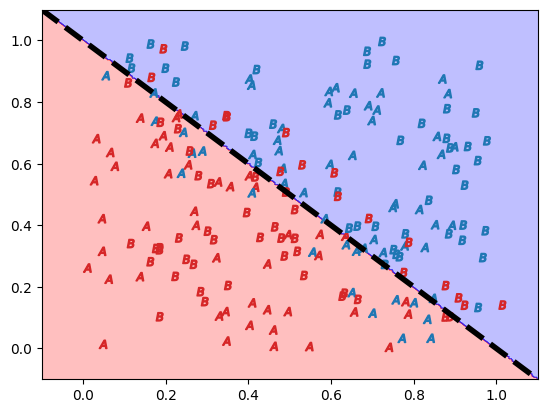

In [3]:
# for reproducibility
torch.manual_seed(42)

# generate data
p1, p2, alpha = 0.5, 0.5, 0.1
x_train, y_train, s_train = generate_unfair_data(250, p1=p1, p2=p2, alpha=alpha)

n_train = 200
x_val, y_val, s_val = x_train[n_train:], y_train[n_train:], s_train[n_train:]
x_train, y_train, s_train = x_train[:n_train], y_train[:n_train], s_train[:n_train]

# test data
x_test, y_test, s_test = generate_unfair_data(50, p1=p1, p2=p2, alpha=alpha)


visualize_unfair_data((x_train, y_train, s_train), domain=(-0.1, 1.1, -0.1, 1.1))

plt.show()

# Non-Robust Training

Here, we train a network without robust optimization.

In [4]:
# for reproducibility
torch.manual_seed(42)

# create linear network
my_net = net.NN(lay.singleLayer(2, 1, act=act.identityActivation(), bias=True))

# create objective function
fctn = ObjectiveFunctionLogisticRegression(my_net)

# choose optimizer
opt = torch.optim.Adam(fctn.parameters(), lr=1e-2)

# construct trainer
trainer = TrainerSGD(opt, max_epochs=20)

# train!
results_train = trainer.train(fctn, (x_train, y_train, s_train), (x_val, y_val, s_val), (x_test, y_test, s_test), 
                              verbose=True, robust=False)


                                             running                       train                         val                           
epoch          time           lr             loss           acc            loss           acc            loss           acc            
-1             0.0000         1.0000e-02     0.0000e+00     0.0000         6.4690e-01     52.5000        6.4141e-01     51.6667        
0              0.1080         1.0000e-02     6.3634e-01     59.0000        6.2474e-01     65.5000        6.1881e-01     64.0000        
1              0.0721         1.0000e-02     6.2245e-01     65.5000        6.1554e-01     67.0000        6.0874e-01     67.6667        
2              0.0674         1.0000e-02     6.1381e-01     73.0000        6.0720e-01     71.0000        6.0000e-01     73.3333        
3              0.0519         1.0000e-02     6.0588e-01     71.5000        5.9995e-01     73.5000        5.9226e-01     75.3333        
4              0.0582         1.0000e-02     5.9

In [5]:
# compute results
results_eval = evaluator.evaluate(fctn, (x_train, y_train, s_train), (x_val, y_val, s_val), (x_test, y_test, s_test))

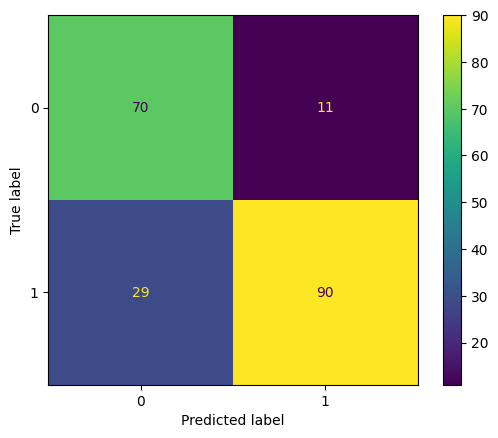

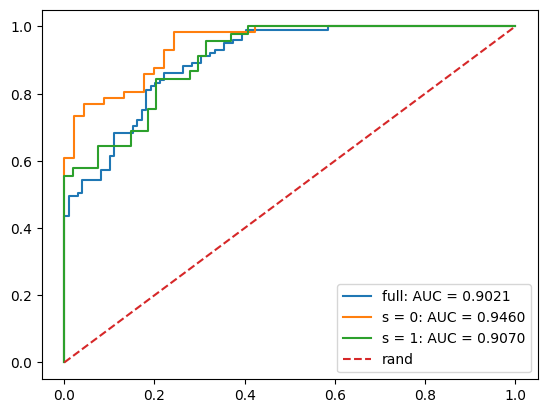

In [6]:
from sklearn import metrics
import numpy as np
from operator import itemgetter


cm = itemgetter(*('TN', 'FN', 'FP', 'TP'))(results_eval['train']['full']['stats'])
metrics.ConfusionMatrixDisplay(np.array(cm).reshape(2, -1)).plot()
plt.show()

for j in ('full', 's = 0', 's = 1'):
    fpr, tpr, auc = itemgetter(*('fpr', 'tpr', 'auc'))(results_eval['train'][j])
    plt.plot(fpr, tpr, label=j + ': AUC = %0.4f' % auc)

plt.plot(torch.linspace(0, 1, 100), torch.linspace(0, 1, 100), '--', label='rand')

plt.legend()
plt.show()


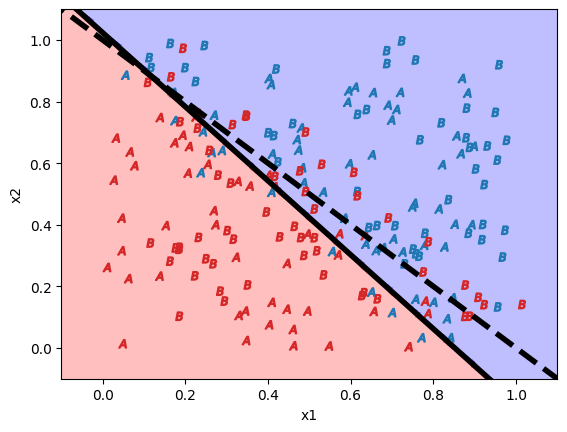

In [7]:
# plot prediction (solid line is the prediction, dashed line is y = -x + 1)
visualize_unfair_data((x_train, y_train, s_train), fctn.net, show_orig=True, domain=(-2, 2, -2, 2))
plt.xlim([-0.1, 1.1])
plt.ylim([-0.1, 1.1])
plt.xlabel('x1')
plt.ylabel('x2')
plt.show()

# Robust Training

Here, we introduce robust training and compute the results.

In [8]:
# for reproducibility
torch.manual_seed(42)

# create linear network
my_net = net.NN(lay.singleLayer(2, 1, act=act.identityActivation(), bias=True))

# create objective function
fctn_robust = ObjectiveFunctionLogisticRegression(my_net)

# choose optimizer
opt = torch.optim.Adam(fctn_robust.parameters(), lr=1e-2)

# construct trainer
trainer = TrainerSGD(opt, max_epochs=20)

# train!
results_train_robust = trainer.train(fctn_robust, (x_train, y_train, s_train), (x_val, y_val, s_val), (x_test, y_test, s_test), verbose=True, robust=True, radius=1e1)

                                             running                       train                         val                           
epoch          time           lr             loss           acc            loss           acc            loss           acc            
-1             0.0000         1.0000e-02     0.0000e+00     0.0000         6.4690e-01     52.5000        6.4141e-01     51.6667        


_LinAlgError: torch.linalg.solve: (Batch element 1): The solver failed because the input matrix is singular.

In [ ]:
# compute results
results_eval_robust = evaluator.evaluate(fctn_robust, (x_train, y_train, s_train), (x_val, y_val, s_val), (x_test, y_test, s_test))

In [ ]:
# plot results
from sklearn import metrics
import numpy as np
from operator import itemgetter


cm = itemgetter(*('TN', 'FN', 'FP', 'TP'))(results_eval_robust['train']['full']['stats'])
metrics.ConfusionMatrixDisplay(np.array(cm).reshape(2, -1)).plot()
plt.show()

for j in ('full', 's = 0', 's = 1'):
    fpr, tpr, auc = itemgetter(*('fpr', 'tpr', 'auc'))(results_eval_robust['train'][j])
    plt.plot(fpr, tpr, label=j + ': AUC = %0.4f' % auc)

plt.plot(torch.linspace(0, 1, 100), torch.linspace(0, 1, 100), '--', label='rand')

plt.legend()
plt.show()

In [ ]:
# plot prediction (solid line is the prediction, dashed line is y = -x + 1)

visualize_unfair_data((x_train, y_train, s_train), fctn_robust.net, show_orig=True, domain=(-2, 2, -2, 2))
plt.xlim([-0.1, 1.1])
plt.ylim([-0.1, 1.1])
plt.xlabel('x1')
plt.ylabel('x2')
plt.show()

# Fairness Comparison

In [ ]:
# comparison of fairness metrics
from pprint import pprint
print('STANDARD')
pprint(results_eval['train']['fairness'])

print('ROBUST')
pprint(results_eval_robust['train']['fairness'])